In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap

# Tạo dữ liệu mẫu
X, y = shap.datasets.boston()

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Tính SHAP values
# Tạo SHAP explainer
explainer = shap.TreeExplainer(model)

# Tính SHAP values cho tập test
shap_values = explainer.shap_values(X_test)

# Vẽ các biểu đồ SHAP cơ bản
# 1. Summary plot
shap.summary_plot(shap_values, X_test)

# 2. Bar plot của SHAP values trung bình tuyệt đối
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 3. Dependence plot cho feature quan trọng nhất
shap.dependence_plot(0, shap_values, X_test)

# 4. Force plot cho một dự đoán đơn lẻ
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Cirrhosis Patient Survival
## Import thư viện cần thiết 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

def analyze_shap_values(X, y, model=None, plot=True):
    """
    Calculate and analyze SHAP values for a given dataset and model.
    
    Parameters:
    -----------
    X : pandas DataFrame
        Feature matrix
    y : array-like
        Target variable
    model : sklearn estimator, optional
        Pre-trained model. If None, a RandomForest will be trained
    plot : bool, default=True
        Whether to create SHAP plots
        
    Returns:
    --------
    dict : Dictionary containing SHAP values and feature importance
    """
    # Create and train model if not provided
    if model is None:
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        X_explain = X_test
    else:
        X_explain = X
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_explain)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    
    # Calculate feature importance based on SHAP
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('importance', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 6))
        # Summary plot
        shap.summary_plot(shap_values, X_explain, plot_type="bar")
        plt.title("SHAP Feature Importance")
        
        plt.figure(figsize=(10, 8))
        # Detailed summary plot
        shap.summary_plot(shap_values, X_explain)
        plt.title("SHAP Summary Plot")
        
        # SHAP dependence plot for most important feature
        plt.figure(figsize=(10, 6))
        most_important_feature = feature_importance['feature'].iloc[0]
        shap.dependence_plot(most_important_feature, shap_values, X_explain)
        plt.title(f"SHAP Dependence Plot for {most_important_feature}")
    
    return {
        'shap_values': shap_values,
        'feature_importance': feature_importance,
        'explainer': explainer,
        'model': model
    }

# Load and prepare California Housing dataset
california = fetch_california_housing()
feature_names = california.feature_names
X = pd.DataFrame(california.data, columns=feature_names)
y = california.target

# Run SHAP analysis
results = analyze_shap_values(X, y)

# Print feature importance
print("\nFeature Importance Rankings:")
print(results['feature_importance'])

# Example of analyzing specific predictions
sample_data = X.iloc[0:5]  # Take first 5 samples
explainer = results['explainer']
shap_values_sample = explainer.shap_values(sample_data)

print("\nDetailed SHAP values for first 5 predictions:")
for i in range(5):
    print(f"\nSample {i+1}:")
    contributions = pd.DataFrame({
        'Feature': X.columns,
        'SHAP value': shap_values_sample[i]
    }).sort_values('SHAP value', ascending=False)
    print(contributions)

# Example of force plot for a single prediction
plt.figure(figsize=(12, 4))
shap.force_plot(explainer.expected_value, 
                shap_values_sample[0], 
                sample_data.iloc[0],
                feature_names=X.columns,
                matplotlib=True)
plt.title("Force Plot for First Prediction")
plt.tight_layout()

### 1. Đọc dữ liệu 

In [2]:
df = pd.read_csv('cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


### 2. EDA

#### 2.1 Thống kê mô tả dữ liệu 

In [3]:
df.shape

(418, 20)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [5]:
cat_cols=['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',	'Edema', 'Stage']
num_cols=["N_Days",'Age' "Bilirubin", "Cholesterol",	"Albumin", "Copper", "Alk_Phos","SGOT",	"Tryglicerides", "Platelets", "Prothrombin"]

In [6]:
# df['Stage']=df['Stage'].astype('object') # chuyển Stage về đúng kiểu dữ liệu 

In [7]:
df.describe(include = 'object').T  # thống kê với dữ liệu phân loại 

,count,unique,top,freq
Status,418,3,C,232
Drug,312,2,D-penicillamine,158
Sex,418,2,F,374
Ascites,312,2,N,288
Hepatomegaly,312,2,Y,160
Spiders,312,2,N,222
Edema,418,3,N,354


In [8]:
for col in cat_cols:
    print(f'Unique values for "{col}":')
    print(df[col].unique())

Unique values for "Drug":
['D-penicillamine' 'Placebo' nan]
Unique values for "Sex":
['F' 'M']
Unique values for "Ascites":
['Y' 'N' nan]
Unique values for "Hepatomegaly":
['Y' 'N' nan]
Unique values for "Spiders":
['Y' 'N' nan]
Unique values for "Edema":
['Y' 'N' 'S']
Unique values for "Stage":
[ 4.  3.  2.  1. nan]


In [9]:
df.describe().T # thống kê với dữ liệu số học 

,count,mean,std,min,25%,50%,75%,max
ID,418.0,209.500000,120.810458,1.00,105.2500,209.50,313.75,418.00
N_Days,418.0,1917.782297,1104.672992,41.00,1092.7500,1730.00,2613.50,4795.00
Age,418.0,18533.351675,3815.845055,9598.00,15644.5000,18628.00,21272.50,28650.00
Bilirubin,418.0,3.220813,4.407506,0.30,0.8000,1.40,3.40,28.00
Cholesterol,284.0,369.510563,231.944545,120.00,249.5000,309.50,400.00,1775.00
Albumin,418.0,3.497440,0.424972,1.96,3.2425,3.53,3.77,4.64
Copper,310.0,97.648387,85.613920,4.00,41.2500,73.00,123.00,588.00
Alk_Phos,312.0,1982.655769,2140.388824,289.00,871.5000,1259.00,1980.00,13862.40
SGOT,312.0,122.556346,56.699525,26.35,80.6000,114.70,151.90,457.25
Tryglicerides,282.0,124.702128,65.148639,33.00,84.2500,108.00,151.00,598.00


- Tập dữ liệu có 418 dòng, 20 cột
- Đặc trưng phân loại: Drug, Sex, Ascites, Hepatomegaly, Spiders, Edema, Stage
- Đặc trưng số học: N_Days, Bilirubin, Cholesterol, Albumin, Copper, Alk_Pho, SGOT, Tryglicerides, Platelets, Prothrombin, ID
- Đặc trưng phân loại: Status

In [10]:
# chuyển dữ liệu đặc trưng Age từ ngày sang năm
df['Age']= (df['Age']/366.25).round(0).astype(int)

In [11]:
df.drop(['ID'], axis=1, inplace=True)

##### Kiểm tra tính toàn vẹn của dữ liệu 

In [12]:
n_duplicated = df.duplicated(keep = False).sum()
print(f'+ Số dòng trùng: {n_duplicated}')
df[df.duplicated(keep = False)]
if n_duplicated>0:
    print("+ Số dòng loại bỏ: %d"%(len(df[df.duplicated(keep = "first")])))
    df[df_dataset.duplicated(keep = "first")]
has_null = df.isnull().sum().any()
print(f'+ Có giá trị Null: {has_null}')
if has_null:
    print("---Số lượng giá trị Null trong từng cột:")
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0])

+ Số dòng trùng: 0
+ Có giá trị Null: True
---Số lượng giá trị Null trong từng cột:
Drug             106
Ascites          106
Hepatomegaly     106
Spiders          106
Cholesterol      134
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64


#### 2.2. Trực quan hóa dữ liệu 

##### Đặc trưng phân loại

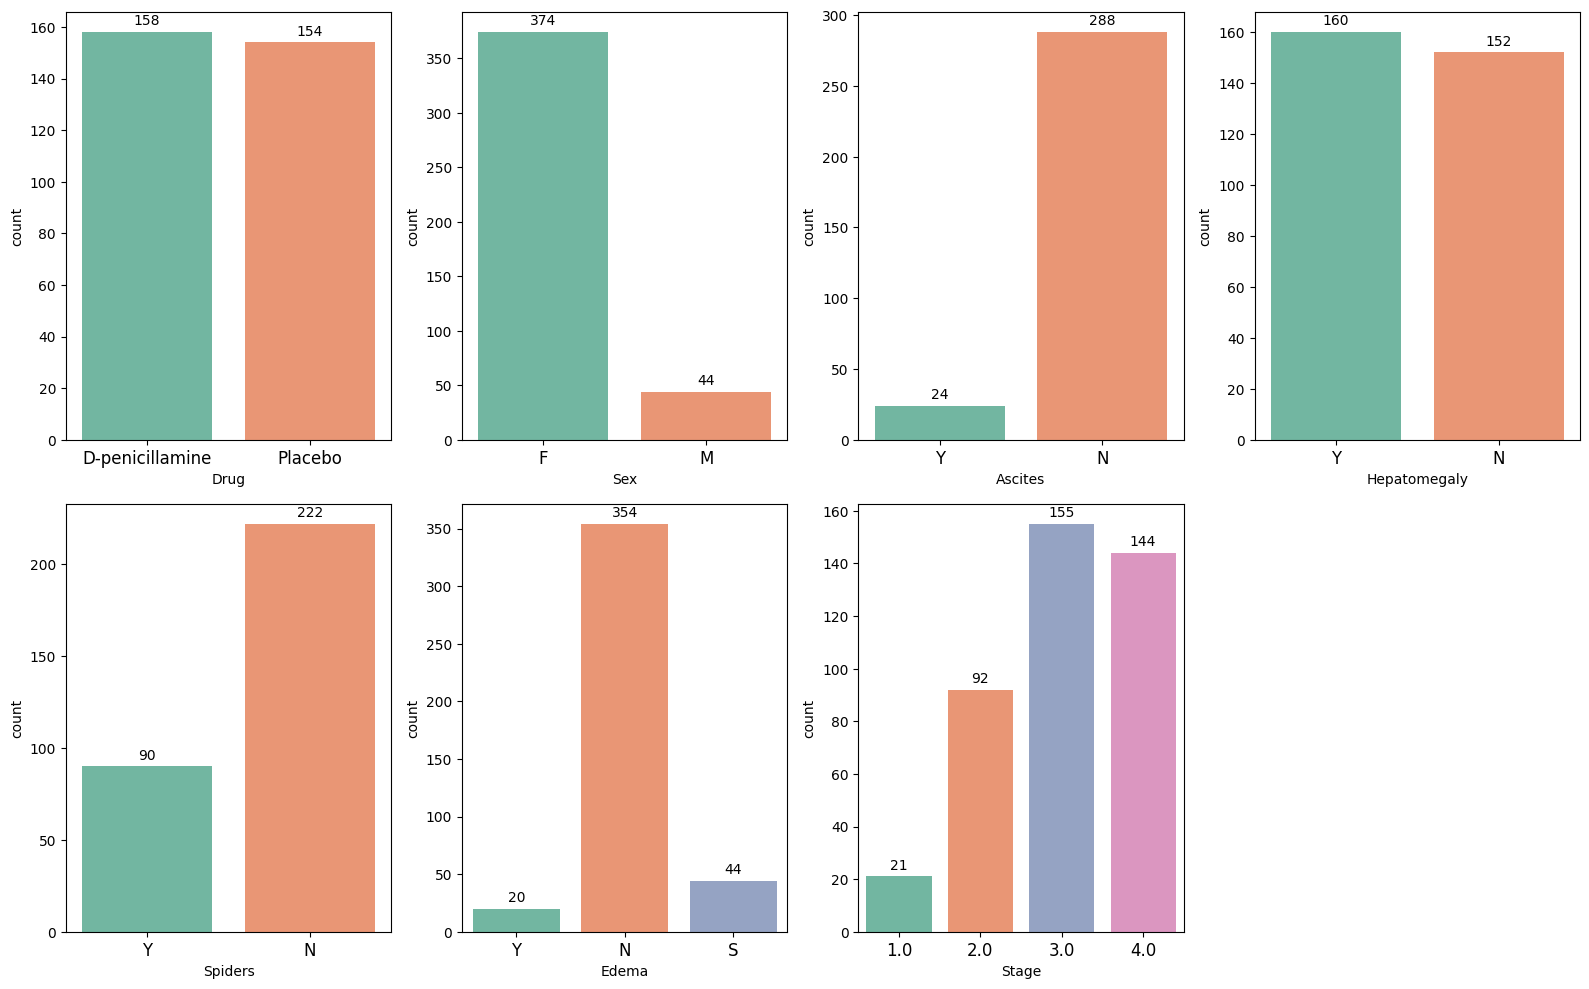

In [13]:
plt.figure(figsize=(16, 10))

categorical_columns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
palette = sns.color_palette("Set2")
# hue_column = 'Status'  # Cột dùng để phân nhóm (hue)

# Tính toán số lượng subplot cần thiết
n_cols = 4  # Số cột trong grid
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

for i, column in enumerate(categorical_columns, 1):
    ax = plt.subplot(n_rows, n_cols, i)  # Lấy từng trục subplot
    sns.countplot(x=column, data=df, palette=palette, ax=ax)  # Thêm hue vào biểu đồ , hue=hue_column
    
    # Thêm số lượng lên đầu cột
    for p in ax.patches:
        if p.get_height() > 0:  # Chỉ thêm số nếu chiều cao > 0
            ax.annotate(
                f'{int(p.get_height())}',  # Số lượng
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Vị trí
                ha='center',  # Căn giữa theo trục x
                va='bottom',  # Căn dưới theo trục y
                fontsize=10,  # Kích thước chữ
                color='black',  # Màu chữ
                xytext=(0, 3),  # Khoảng cách từ cột
                textcoords='offset points'  # Tham chiếu khoảng cách theo điểm
            )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Xoay nhãn trục X nếu cần

plt.tight_layout()  # Điều chỉnh khoảng cách giữa các subplot
plt.show()


##### Đặc trưng số học

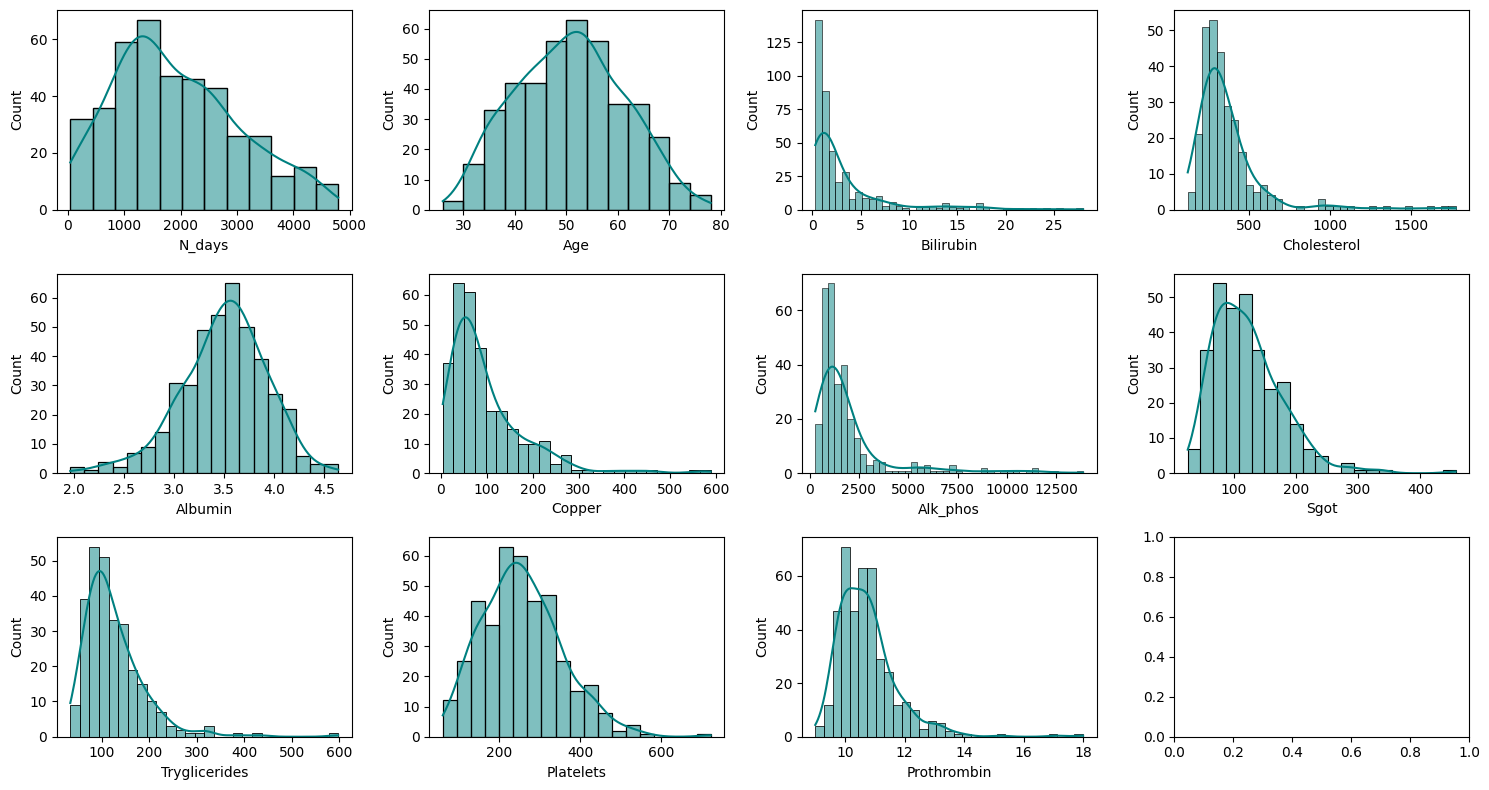

In [14]:
fig, ax = plt.subplots(3,4 , figsize=(15, 8))
variables = ["N_Days", 'Age', "Bilirubin",	"Cholesterol",	"Albumin", "Copper", "Alk_Phos","SGOT",	"Tryglicerides", "Platelets", "Prothrombin"]
for i, variable in enumerate(variables):
    row, col = divmod(i, 4)
    sns.histplot(data=df, x=variable, kde=True, color='teal', ax=ax[row, col])
    ax[row, col].set_xlabel(variable.capitalize())
    ax[row, col].set_ylabel("Count")

plt.tight_layout()
plt.show()

##### Biến mục tiêu

In [15]:
# Number of status values
df.Status.value_counts()

Status
C     232
D     161
CL     25
Name: count, dtype: int64

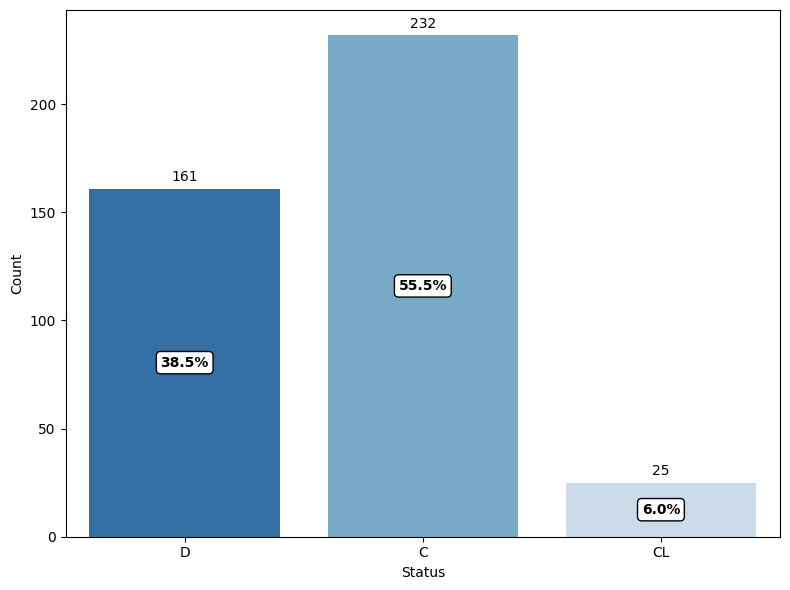

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Vẽ biểu đồ countplot
sns.countplot(x='Status', data=df, palette="Blues_r", ax=ax)

# Thiết lập nhãn cho trục y
ax.set_ylabel('Count')

# Tính tổng số dòng
total = len(df)

# Hiển thị số lượng trên các cột
for label in ax.containers:
    ax.bar_label(label, padding=3, fontsize=10)

# Hàm hiển thị phần trăm trên cột
def set_percentage_on_bars(ax):
    for p in ax.patches:
        # Tính phần trăm của mỗi cột
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        # Tọa độ của phần trăm (ở giữa cột)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() / 2
        ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

# Áp dụng hàm hiển thị phần trăm ở giữa cột
set_percentage_on_bars(ax)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

##### Phát hiện giá trị ngoại lai với box plot

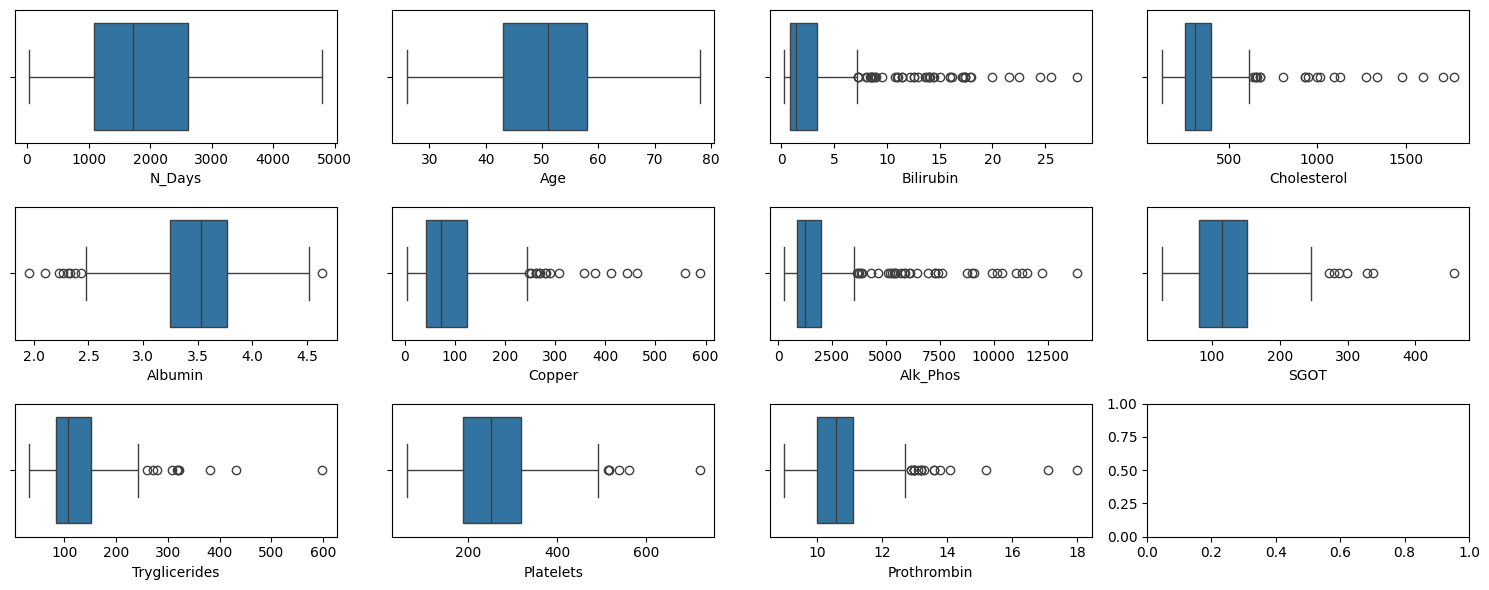

In [17]:
fig, axes = plt.subplots(3,4, figsize=(15, 6))
numerical_columns = ["N_Days", 'Age', "Bilirubin",	"Cholesterol",	"Albumin", "Copper", "Alk_Phos","SGOT",	"Tryglicerides", "Platelets", "Prothrombin"]
# Đảm bảo axes là một mảng 1D
axes = axes.flatten()

# Vẽ boxplot cho từng cột trong numerical_columns
for i, column in enumerate(numerical_columns):
    sns.boxplot(ax=axes[i], x=df[column])
    axes[i].set_xlabel(column)  # Đặt tên cột làm nhãn

# Điều chỉnh layout và hiển thị
plt.tight_layout()
plt.show()

### 3. Xử lý dữ liệu

#### 3.1. Xử lý dữ liệu thiếu

In [18]:
df.isnull().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

<Axes: >

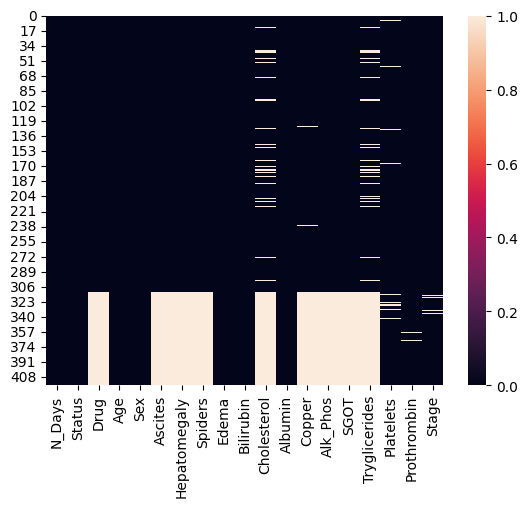

In [19]:
sns.heatmap(data=df.isnull())

In [20]:
# Handling missing numerical values
num_cols = ['Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides']
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Deleting some missing rows
remove_row_cols = ['Platelets', 'Prothrombin', 'Stage']
for i in remove_row_cols:
    df = df[pd.notnull(df[i])]
    
# Handling missing categorical values
missing_categorical_columns = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']
for i in missing_categorical_columns:
    df[i] = df[i].fillna('Missing')

In [21]:
df.shape

(399, 19)

<Axes: >

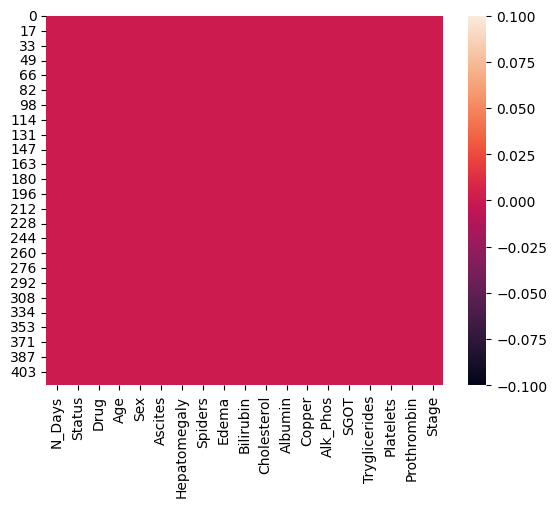

In [22]:
sns.heatmap(data=df.isnull())

#### 3.2 Mã hóa đặc trưng phân loại 

In [23]:
categorical_columns = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
mapping = {'C': 0, 'CL': 1, 'D': 2}
mapping_S = {'M': 0, 'F':1}
df_encoded['Status'] = df_encoded['Status'].map(mapping)
df_encoded['Sex'] = df_encoded['Sex'].map(mapping_S) 

for col in df_encoded.select_dtypes(include=['bool']).columns:
    df_encoded[col] = df_encoded[col].astype(int)
df_encoded.head().T

,0,1,2,3,4
N_Days,400.00,4500.00,1012.00,1925.00,1504.00
Status,2.00,0.00,2.00,2.00,1.00
Age,59.00,56.00,70.00,55.00,38.00
Sex,1.00,1.00,0.00,1.00,1.00
Bilirubin,14.50,1.10,1.40,1.80,3.40
Cholesterol,261.00,302.00,176.00,244.00,279.00
Albumin,2.60,4.14,3.48,2.54,3.53
Copper,156.00,54.00,210.00,64.00,143.00
Alk_Phos,1718.00,7394.80,516.00,6121.80,671.00
SGOT,137.95,113.52,96.10,60.63,113.15


In [24]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, 0 to 417
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   N_Days          399 non-null    int64  
 1   Status          399 non-null    int64  
 2   Age             399 non-null    int32  
 3   Sex             399 non-null    int64  
 4   Bilirubin       399 non-null    float64
 5   Cholesterol     399 non-null    float64
 6   Albumin         399 non-null    float64
 7   Copper          399 non-null    float64
 8   Alk_Phos        399 non-null    float64
 9   SGOT            399 non-null    float64
 10  Tryglicerides   399 non-null    float64
 11  Platelets       399 non-null    float64
 12  Prothrombin     399 non-null    float64
 13  Stage           399 non-null    float64
 14  Drug_Missing    399 non-null    int32  
 15  Drug_Placebo    399 non-null    int32  
 16  Ascites_N       399 non-null    int32  
 17  Ascites_Y       399 non-null    int32  


In [25]:
df_encoded.describe(include='all')
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, 0 to 417
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   N_Days          399 non-null    int64  
 1   Status          399 non-null    int64  
 2   Age             399 non-null    int32  
 3   Sex             399 non-null    int64  
 4   Bilirubin       399 non-null    float64
 5   Cholesterol     399 non-null    float64
 6   Albumin         399 non-null    float64
 7   Copper          399 non-null    float64
 8   Alk_Phos        399 non-null    float64
 9   SGOT            399 non-null    float64
 10  Tryglicerides   399 non-null    float64
 11  Platelets       399 non-null    float64
 12  Prothrombin     399 non-null    float64
 13  Stage           399 non-null    float64
 14  Drug_Missing    399 non-null    int32  
 15  Drug_Placebo    399 non-null    int32  
 16  Ascites_N       399 non-null    int32  
 17  Ascites_Y       399 non-null    int32  


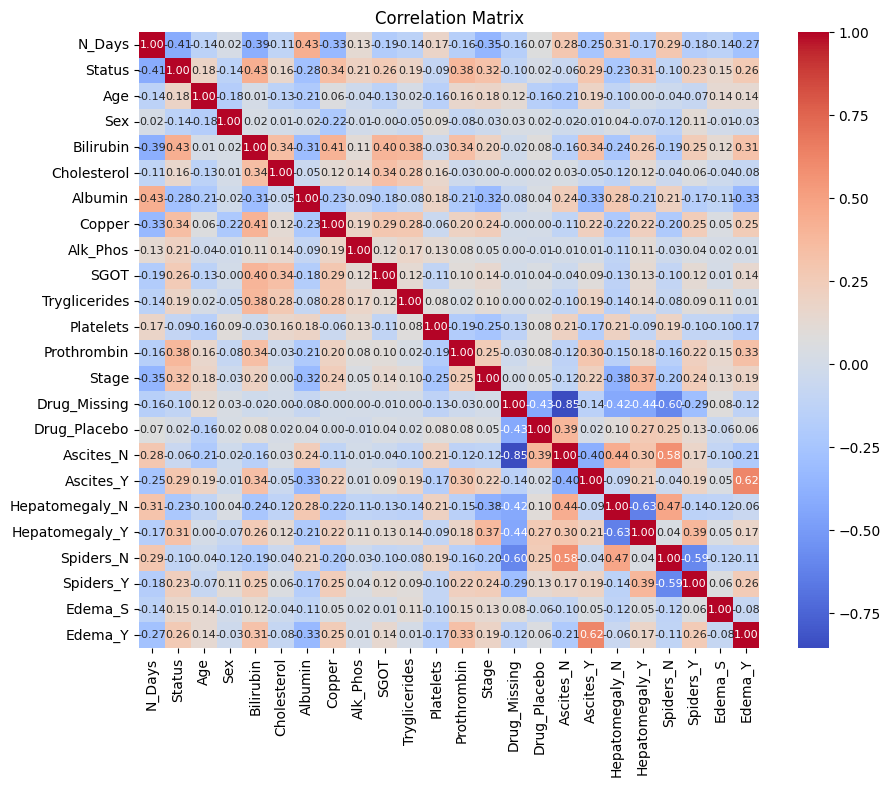

In [26]:
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

#### 3.3. Chia dữ liệu 

In [27]:
X = df_encoded.drop(['Status'], axis=1)
y = df_encoded[['Status']]

In [28]:
X_train, x_test, y_train, y_test = train_test_split (X, y, test_size=0.25, random_state = 42)

#### 3.4. Xử lý mất cân bằng dữ liệu với SMOTE

In [29]:
smote = SMOTE(random_state=42) # Áp dụng SMOTE để tăng mẫu lớp thiểu số X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [30]:
X_train_smote.shape, y_train_smote.shape, y_train_smote.value_counts()

((519, 23),
 (519, 1),
 Status
 0         173
 1         173
 2         173
 Name: count, dtype: int64)

#### 3.5. Chuẩn hóa dữ liệu

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_smote_mm_scaled = scaler.fit_transform(X_train_smote)
X_test_mm_scaled = scaler.fit_transform(x_test)

In [32]:
# chuẩn hóa với standardScaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train_smote)
X_test_st= scaler.transform(x_test)

In [33]:
X_train_st.shape

(519, 23)

#### XXX chuẩn hóa với random over sampler 

In [34]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
df_ros = pd.concat([X_resampled, y_resampled], axis=1)
df_ros = df.sample(frac=1, random_state=42).reset_index(drop=True)

### 4. Xây dựng mô hình

#### Feature Selection 

##### Forward Feature Selection of Wrapped Method

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

selected_features = []

# Define the machine learning model (in this case, a Random Forest Classifier)
model = RandomForestClassifier()

# Define the number of features you want to select
num_features_to_select = 10

while len(selected_features) < num_features_to_select:
    best_score = -1
    best_feature = None

    for feature_idx in range(X.shape[1]):
        if feature_idx in selected_features:
            continue

        # Try adding the feature to the selected set
        candidate_features = selected_features + [feature_idx]

        # Evaluate the model's performance using cross-validation
        scores = cross_val_score(model, X.iloc[:, candidate_features], y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # Keep track of the best-performing feature
        if mean_score > best_score:
            best_score = mean_score
            best_feature = feature_idx

    if best_feature is not None:
        selected_features.append(best_feature)
        print(f"Selected Feature {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")

print("Selected feature indices:", selected_features)

Selected Feature 1: 11, Mean Accuracy: 0.6892
Selected Feature 2: 16, Mean Accuracy: 0.6917
Selected Feature 3: 2, Mean Accuracy: 0.6918
Selected Feature 4: 3, Mean Accuracy: 0.6968
Selected Feature 5: 6, Mean Accuracy: 0.7469
Selected Feature 6: 10, Mean Accuracy: 0.7543
Selected Feature 7: 22, Mean Accuracy: 0.7693
Selected Feature 8: 9, Mean Accuracy: 0.7543
Selected Feature 9: 19, Mean Accuracy: 0.7569
Selected Feature 10: 14, Mean Accuracy: 0.7518
Selected feature indices: [11, 16, 2, 3, 6, 10, 22, 9, 19, 14]


In [36]:
print("Selected feature names:", X.columns[selected_features].tolist())

Selected feature names: ['Prothrombin', 'Ascites_Y', 'Sex', 'Bilirubin', 'Copper', 'Platelets', 'Edema_Y', 'Tryglicerides', 'Spiders_N', 'Drug_Placebo']


##### Recursive Feature Elimination (RFE)

In [37]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the machine learning model (in this case, a Random Forest Classifier)
model = RandomForestClassifier()

# Specify the number of features you want to retain
num_features_to_retain = 10

# Initialize the RFE selector with the model and the number of features to retain
rfe = RFE(estimator=model, n_features_to_select=num_features_to_retain)

# Fit the RFE selector to your data
rfe.fit(X, y)

# Get the selected features
selected_features = np.where(rfe.support_)[0]

print("Selected feature indices:", selected_features)

# Evaluate model performance with the selected features using cross-validation
scores = cross_val_score(model, X.iloc
                         [:, selected_features], y, cv=5, scoring='accuracy')
mean_accuracy = np.mean(scores)
print(f"Mean Accuracy with Selected Features: {mean_accuracy:.4f}")

Selected feature indices: [ 0  1  3  4  5  6  7  8 10 11]
Mean Accuracy with Selected Features: 0.7621


In [38]:
print("Selected feature names:", X.columns[selected_features].tolist())

Selected feature names: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Platelets', 'Prothrombin']


#### Mô hình 

In [39]:
# import các thư viện cần thiết 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score # hàm tính toán độ chính xác của mô hình phân loại
from sklearn.metrics import classification_report # hàm in ra báo cáo phân loại cho từng lớp về các chỉ số precision, recall, f1 - score, support
from sklearn.preprocessing import LabelEncoder # mã hóa các biến phân loại thành giá trị số
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# Model

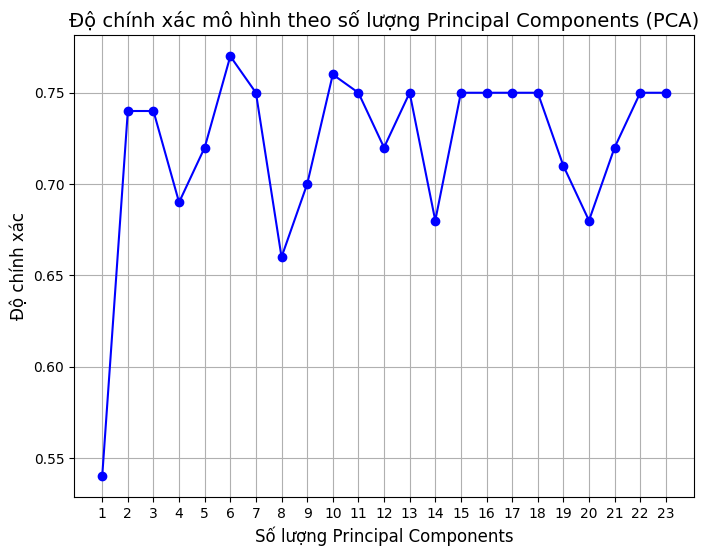

In [40]:
#?????????????
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# List để lưu kết quả độ chính xác theo số lượng PCA components
accuracy_list = []

# Thử nghiệm với số lượng PCA components khác nhau
for n_components in range(1, X.shape[1] + 1):
    # Áp dụng PCA với n_components
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(x_test)
    
    # Huấn luyện mô hình Logistic Regression
    model = LogisticRegression(max_iter=200)
    model.fit(X_train_pca, y_train)
    
    # Dự đoán và tính toán độ chính xác
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Lưu độ chính xác vào list
    accuracy_list.append(accuracy)

# Vẽ biểu đồ độ chính xác theo số lượng PCA components
plt.figure(figsize=(8, 6))
plt.plot(range(1, X.shape[1] + 1), accuracy_list, marker='o', color='b', linestyle='-', markersize=6)
plt.title('Độ chính xác mô hình theo số lượng Principal Components (PCA)', fontsize=14)
plt.xlabel('Số lượng Principal Components', fontsize=12)
plt.ylabel('Độ chính xác', fontsize=12)
plt.grid(True)
plt.xticks(range(1, X.shape[1] + 1))
plt.show()


#### Xây dựng mô hình và đánh giá với K-fold

In [41]:
k_fold = 5
random_state = 42

In [42]:
kfold = KFold (n_splits = k_fold, shuffle = True, random_state = random_state)
print (f'+X_train: {len(X_train_smote)}')
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train_smote, y_train_smote)):
    print(f'Fold {fold}: ')
    print(f'+ train_idx: {train_idx}')
    print(f'+ valid_idx: {valid_idx}')
    print(f'+ train / valid: {valid_idx}')
    pass

+X_train: 519
Fold 0: 
+ train_idx: [  1   3   4   5   7   8  12  13  14  15  16  17  19  20  21  23  24  25
  26  27  28  29  31  32  34  35  36  37  38  40  41  42  43  44  45  47
  48  49  50  51  52  53  54  56  57  58  59  60  61  62  64  65  66  67
  71  74  75  80  81  83  85  86  87  88  89  91  92  94  95  96  97  98
  99 100 102 103 105 106 107 108 109 110 111 112 113 114 115 116 118 119
 120 121 122 123 125 126 127 128 129 130 133 134 135 136 138 139 141 142
 143 144 145 146 147 149 150 151 152 154 156 157 159 160 161 162 163 164
 165 166 168 169 170 171 174 175 178 179 181 182 183 184 186 187 188 189
 190 191 193 194 195 196 197 198 199 200 201 202 204 205 206 207 208 209
 211 212 213 214 215 216 217 219 220 221 223 224 225 226 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 250 251
 252 254 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 276 277 279 280 282 283 284 285 287 288 290 291 292 293 294
 295 296 298 30

In [43]:
# Mô hình mặc định (models, results, hyper-parameters)
baseline_models  = {}
baseline_results = {}

# khởi tạo các tham số mặc định
baseline_models['kNN']   = KNeighborsClassifier()
baseline_models['Naive Bayes']  = GaussianNB()
baseline_models['SVM']  = SVC(random_state=random_state)
baseline_models['DT'] = DecisionTreeClassifier(random_state=random_state)
baseline_models['RF']   =RandomForestClassifier(random_state=random_state)
baseline_models['AdaBoost']  = AdaBoostClassifier()
baseline_models['GB']   = GradientBoostingClassifier()
baseline_models['LDA']   =  LinearDiscriminantAnalysis()
baseline_models['LR']   = LogisticRegression()
baseline_models['XGB']   =  XGBClassifier(random_state=42)
# Huấn luyện từng mô hình cơ sở
for model_name in baseline_models:

    baseline_results[model_name] = []

    print(f'Model [{model_name}]:')

    # Chiến lược chia dữ liệu trên tập X_train
    kfold = KFold(n_splits=k_fold, shuffle=True, random_state=random_state)

    # Tách X_train, y_train thành 2 tập train, valid trên từng fold
    # Với mỗi fold, train cho huấn luyện, valid cho lượng giá và điều chỉnh tham số
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train_smote, y_train_smote)):
        # Chia 2 tập thành train/valid
        X1_train, y1_train = X_train_smote.iloc[train_idx], y_train_smote.iloc[train_idx]
        X1_valid, y1_valid = X_train_smote.iloc[valid_idx], y_train_smote.iloc[valid_idx]


        # Lấy mô hình khởi tạo
        model_clf = sklearn.base.clone(baseline_models[model_name])

        # Huấn luyện mô hình
        model_clf.fit(X1_train, y1_train)

        # Lượng giá mô hình
        y1_pred_valid = model_clf.predict(X1_valid)

        # Tính toán metrics: accuracy
        valid_acc = accuracy_score(y1_valid, y1_pred_valid)

        # Lưu metrics trên từng fold
        baseline_results[model_name].append(valid_acc)

        pass # fold
    # Chúng ta đơn giản sử dụng lệnh bên dưới thay cho khối lệnh k-fold bên trên
    # baseline_results[name] = cross_val_score(model_clf, X_train, y_train, cv = kfold, scoring="accuracy")

    # hiển thị tham số mô hình
    print(f'+ params = {baseline_models[model_name].get_params()}')

    # hiển thị kết quả trên từng fold
    print(f'+ acc = {baseline_results[model_name]}')

    # trung bình kết quả +/ std cho tất cả các fold,
    # std: độ lệch chuẩn=> nếu cùng mean thì độ lệch nào nhỏ hơn thì tốt hơn vì ổn định và tập trung hơn
    s_msg = f'+ mean_acc = {np.mean(baseline_results[model_name]):.6f} +/- {np.std(baseline_results[model_name]):.6f}'
    print(s_msg)
    print()

    # Huấn luyện lại với trên toàn bộ dữ liệu train (re-fit all train_data)
    baseline_models[model_name].fit(X_train_smote, y_train_smote)
    pass # model

Model [kNN]:
+ params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
+ acc = [0.7884615384615384, 0.7596153846153846, 0.6538461538461539, 0.6923076923076923, 0.6893203883495146]
+ mean_acc = 0.716710 +/- 0.049572

Model [Naive Bayes]:
+ params = {'priors': None, 'var_smoothing': 1e-09}
+ acc = [0.7403846153846154, 0.7115384615384616, 0.6442307692307693, 0.7884615384615384, 0.7378640776699029]
+ mean_acc = 0.724496 +/- 0.047187

Model [SVM]:
+ params = {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
+ acc = [0.5769230769230769, 0.5673076923076923, 0.49038461538461536, 0.6057692307692307, 0.5728155339805825]
+ mean_acc = 0.562640 +/- 0.038498

Model [DT]:
+ pa

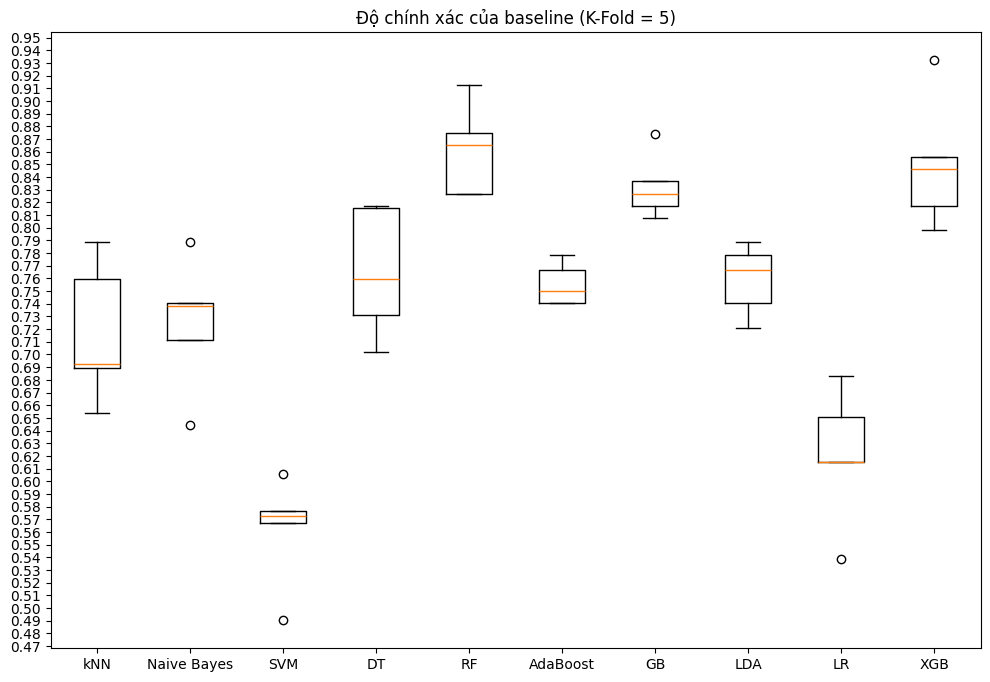

In [44]:
# In biểu đồ box-plot trên độ chính xác với k-fold
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
plt.boxplot(baseline_results.values())
plt.gca().set_xticklabels(baseline_results.keys())
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.title(f'Độ chính xác của baseline (K-Fold = {k_fold})')
plt.show()

In [45]:
tunning_results = {
    "best_clf"   : {},
    "best_score" : {},
}

tunning_models  = {}
tunning_params  = {}

# khởi tạo các tham số mặc định
# KNN
tunning_models['kNN'] = KNeighborsClassifier()
tunning_params['kNN'] = {
    'n_neighbors': [2, 4, 6, 8, 10],
}

# Naive Bayes
tunning_models['Naive Bayes'] = GaussianNB()
tunning_params['Naive Bayes'] = {
    # GaussianNB không có nhiều tham số để tối ưu
    # Thêm vào đây nếu cần
}


# Decision Tree
tunning_models['DT'] = DecisionTreeClassifier(random_state=random_state)
tunning_params['DT'] = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Random Forest
tunning_models['RF'] = RandomForestClassifier(random_state=random_state)
tunning_params['RF'] = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
}

# AdaBoost
tunning_models['AdaBoost'] = AdaBoostClassifier(random_state=random_state)
tunning_params['AdaBoost'] = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
}

# Gradient Boosting
tunning_models['GB'] = GradientBoostingClassifier(random_state=random_state)
tunning_params['GB'] = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 10],
}

# Linear Discriminant Analysis
tunning_models['LDA'] = LinearDiscriminantAnalysis()
tunning_params['LDA'] = {
    'solver': ['svd', 'lsqr', 'eigen'],
}


# Logistic Regression
tunning_models['LR'] = LogisticRegression(random_state=random_state)
tunning_params['LR'] = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
}
tunning_models['XGBoost'] = XGBClassifier(eval_metric='mlogloss')
tunning_params['XGBoost'] = {
    'n_estimators': [50, 100, 200],  # Số lượng cây
    'learning_rate': [0.01, 0.1, 0.3],  # Tốc độ học
    'max_depth': [3, 6, 9],  # Độ sâu của cây
    # 'subsample': [0.8, 0.9, 1.0],  # Tỷ lệ mẫu sử dụng trong mỗi cây
    # 'colsample_bytree': [0.8, 0.9, 1.0],  # Tỷ lệ cột sử dụng trong mỗi cây
    'gamma': [0, 0.1, 0.2],  # Điều chỉnh sự phân nhánh của cây
}
for model_name in tunning_models:
    model_clf = tunning_models[model_name]

    print(f'Model [{model_name}]:')

    kfold = KFold(n_splits=k_fold, shuffle=True, random_state=random_state)

    grid_clf = GridSearchCV(estimator=model_clf,
                            param_grid=tunning_params[model_name],
                            cv = kfold, scoring="accuracy")
    grid_result = grid_clf.fit(X_train_smote, y_train_smote)

    # store best model
    tunning_results["best_clf"][model_name] = grid_clf.best_estimator_

    # get search results
    tunning_results["best_score"][model_name] = grid_result.best_score_


    # information
    print(f'+ Best score: {grid_result.best_score_}')
    print(f'+ Best turnning params: {grid_result.best_params_}')
    print(f'+ Best full params: {grid_clf.best_estimator_.get_params()}')
    print()

    pass

Model [kNN]:
+ Best score: 0.737864077669903
+ Best turnning params: {'n_neighbors': 2}
+ Best full params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}

Model [Naive Bayes]:
+ Best score: 0.7244958924570575
+ Best turnning params: {}
+ Best full params: {'priors': None, 'var_smoothing': 1e-09}

Model [DT]:
+ Best score: 0.7746079163554892
+ Best turnning params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
+ Best full params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}

Model [RF]:
+ Best score: 0.8767363704256909
+ Best turnning params: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
+ Best full pa

Baseline [kNN]
+ acc = 0.550
[[30 17  4]
 [ 3  0  1]
 [ 8 12 25]]


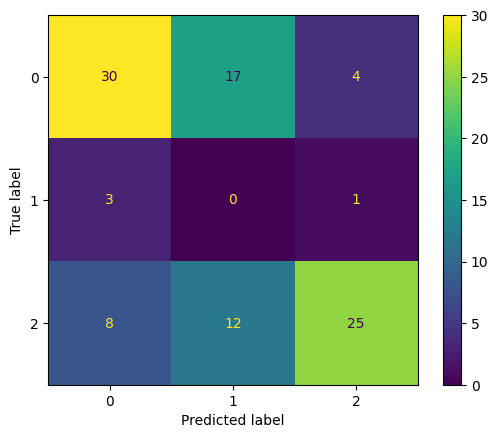

Baseline [Naive Bayes]
+ acc = 0.630
[[35 10  6]
 [ 2  1  1]
 [11  7 27]]


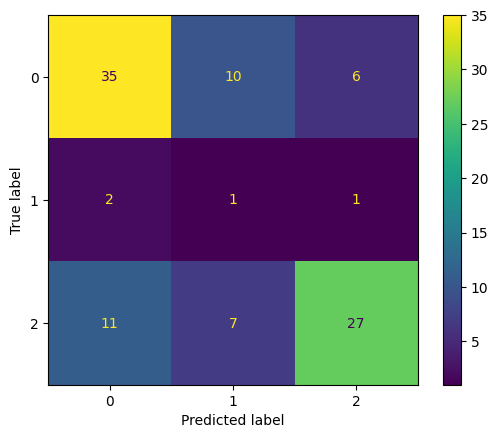

Baseline [SVM]
+ acc = 0.520
[[26 23  2]
 [ 0  3  1]
 [ 8 14 23]]


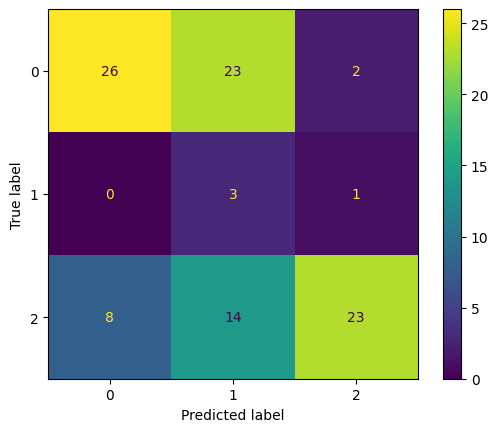

Baseline [DT]
+ acc = 0.630
[[32  5 14]
 [ 1  1  2]
 [10  5 30]]


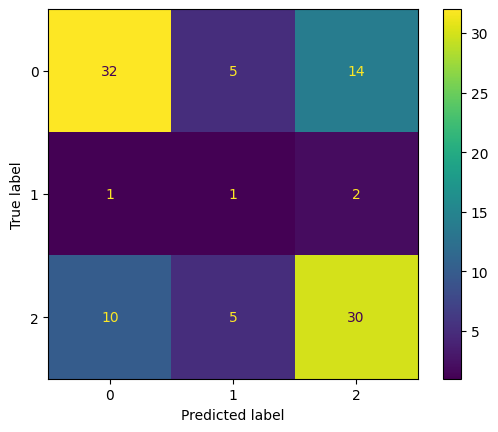

Baseline [RF]
+ acc = 0.780
[[44  1  6]
 [ 2  0  2]
 [10  1 34]]


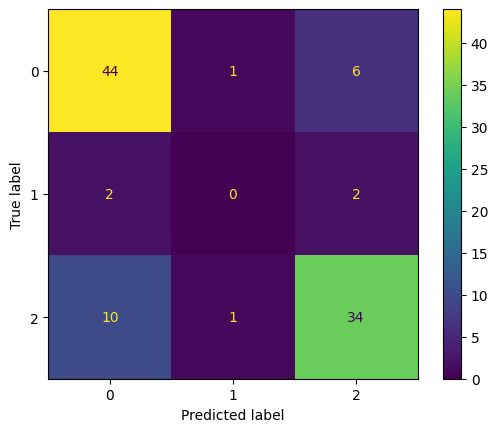

Baseline [AdaBoost]
+ acc = 0.700
[[38  7  6]
 [ 1  2  1]
 [10  5 30]]


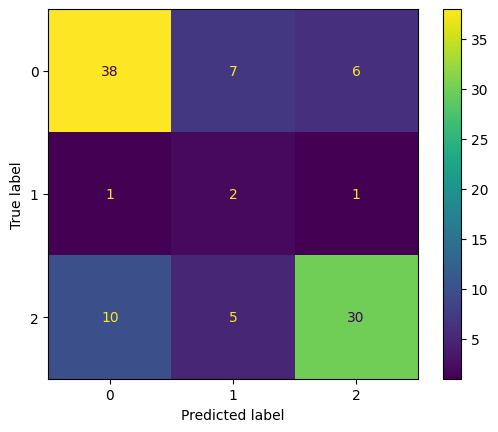

Baseline [GB]
+ acc = 0.730
[[39  4  8]
 [ 1  1  2]
 [ 9  3 33]]


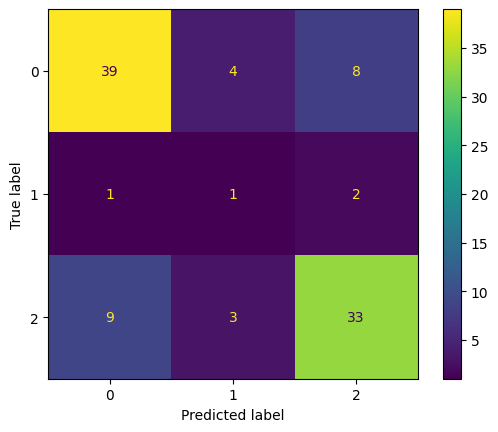

Baseline [LDA]
+ acc = 0.770
[[42  1  8]
 [ 2  1  1]
 [10  1 34]]


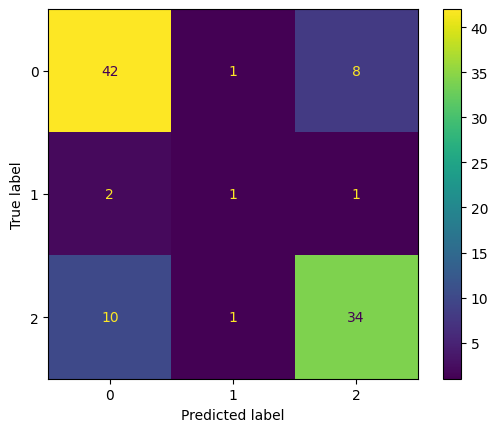

Baseline [LR]
+ acc = 0.560
[[25 12 14]
 [ 0  3  1]
 [ 9  8 28]]


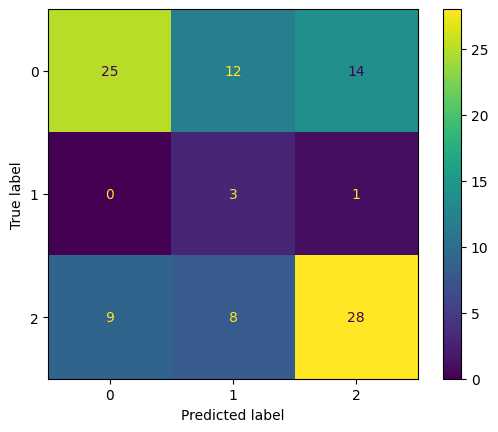

Baseline [XGB]
+ acc = 0.750
[[40  2  9]
 [ 2  1  1]
 [10  1 34]]


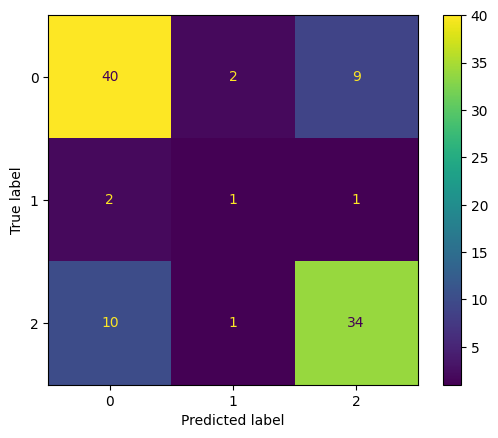

In [46]:
test_models  = {}
test_scores  = {}

# Kiểm tra kết quả trên tập test (baseline)
for model_name in baseline_models:
    model_clf = baseline_models[model_name]
    y_pred_test = model_clf.predict(x_test)
    test_acc = accuracy_score(y_test, y_pred_test)

    # information
    print(f'Baseline [{model_name}]')
    print(f'+ acc = {test_acc:.3f}')

    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.show()

Tunning [kNN]
+ acc = 0.610


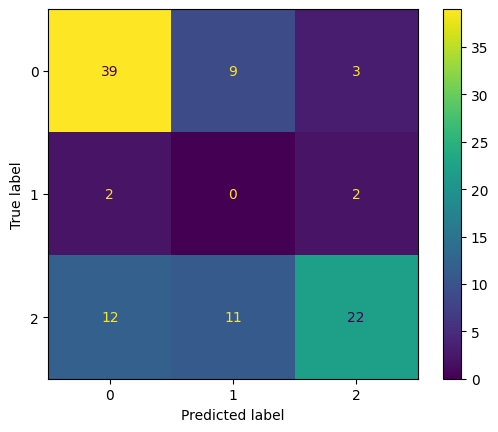

Tunning [Naive Bayes]
+ acc = 0.630


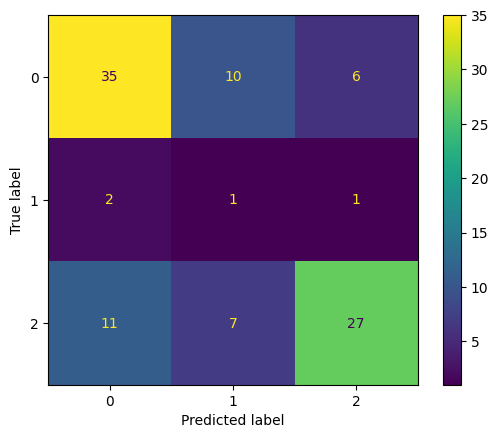

Tunning [DT]
+ acc = 0.670


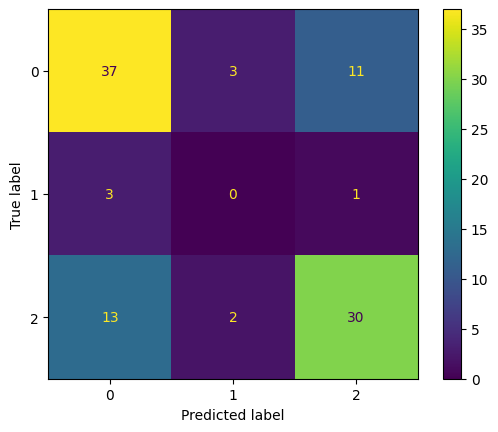

Tunning [RF]
+ acc = 0.750


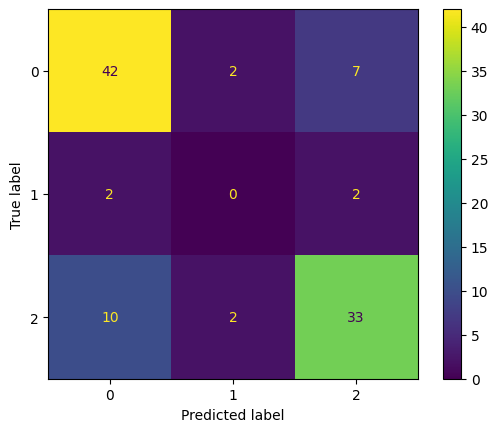

Tunning [AdaBoost]
+ acc = 0.710


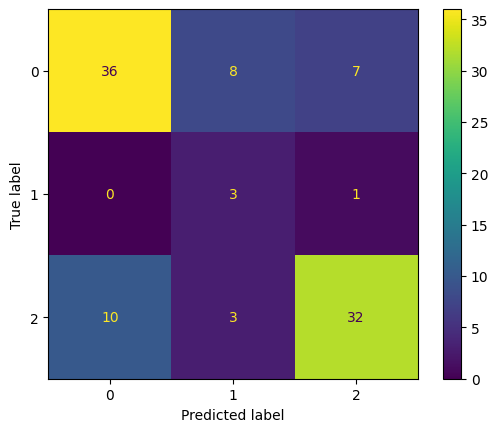

Tunning [GB]
+ acc = 0.760


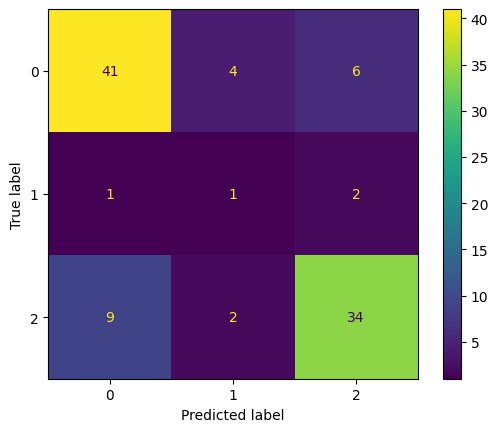

Tunning [LDA]
+ acc = 0.770


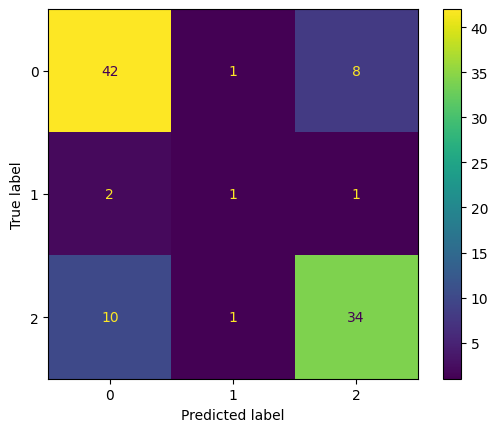

Tunning [LR]
+ acc = 0.710


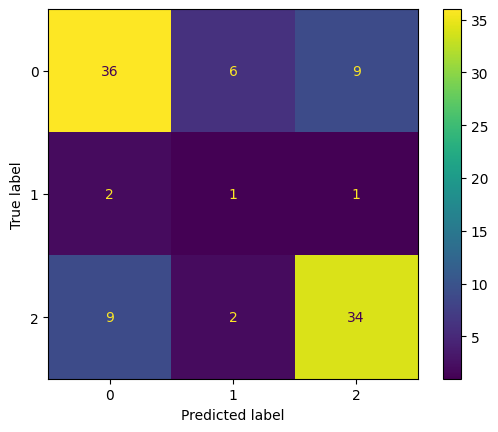

Tunning [XGBoost]
+ acc = 0.730


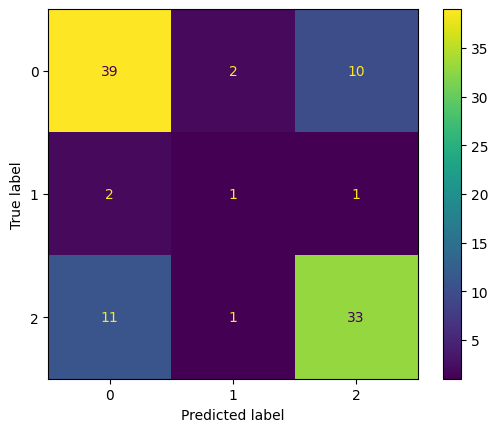

In [47]:
# Kiểm tra kết quả trên tập test (baseline)
for model_name in tunning_models:
    model_clf = tunning_results["best_clf"][model_name]
    y_pred_test = model_clf.predict(x_test)
    test_acc = accuracy_score(y_test, y_pred_test)

    # information
    print(f'Tunning [{model_name}]')
    print(f'+ acc = {test_acc:.3f}')

    cm = confusion_matrix(y_test, y_pred_test)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.show()

In [1]:
import shap
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Danh sách các mô hình
baseline_models = {
    'kNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=42, probability=True),
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GB': GradientBoostingClassifier(random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'LR': LogisticRegression(random_state=42, max_iter=1000),
    'XGB': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Lưu lại tên các đặc trưng từ DataFrame trước khi chuyển đổi thành NumPy array
feature_names = [str(name) for name in selected_features]  # Danh sách tên các đặc trưng

# Chuyển đổi X_train và x_test thành NumPy arrays
X_train_array = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train
x_test_array = x_test.to_numpy() if hasattr(x_test, 'to_numpy') else x_test

# Huấn luyện và phân tích SHAP
for name, model in baseline_models.items():
    print(f"\nAnalyzing model: {name}")
    
    # Huấn luyện mô hình
    try:
        model.fit(X_train_array, y_train)
    except Exception as e:
        print(f"Error training model {name}: {e}")
        continue
    
    # Sử dụng KernelExplainer cho các mô hình không callable như GaussianNB
    try:
        if hasattr(model, 'predict_proba'):  # Kiểm tra xem mô hình có hỗ trợ predict_proba không
            model_predict = lambda x: model.predict_proba(x)  # Hàm dự đoán xác suất
            explainer = shap.KernelExplainer(model_predict, shap.sample(X_train_array, 100))  # Giới hạn số mẫu nền
            shap_values = explainer.shap_values(x_test_array, nsamples=100)  # Giới hạn số mẫu
        else:
            explainer = shap.Explainer(model, shap.sample(X_train_array, 100))  # Giới hạn số mẫu nền
            shap_values = explainer(x_test_array)
    except Exception as e:
        print(f"Error generating SHAP values for {name}: {e}")
        continue
    
    # Kiểm tra lại shap_values và đảm bảo rằng nó có dạng 2D
    if isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 1:
        shap_values = shap_values.reshape(1, -1)
    
    # Hiển thị SHAP summary plot
    try:
        print(f"SHAP Summary Plot for {name}:")
        shap.summary_plot(shap_values, x_test_array, feature_names=feature_names)
    except Exception as e:
        print(f"Error displaying SHAP summary plot for {name}: {e}")


NameError: name 'selected_features' is not defined